<a href="https://colab.research.google.com/github/mancunian1792/LatentSpaceClustering_GenerativeModels/blob/main/ResNet_VAE_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt

import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
class ResNet_VAE(nn.Module):
    def __init__(self, fc_hidden1, fc_hidden2, drop_p, CNN_embed_dim):
        super(ResNet_VAE, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        
        for child in self.resnet.children():
          for param in child.parameters():
            param.requires_grad = False
        
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)
        # Latent vectors mu and sigma
        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables
        self.fc3_logvar = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)  # output = CNN embedding latent variables

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def encode(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        # x = F.dropout(x, p=self.drop_p, training=self.training)
        mu, logvar = self.fc3_mu(x), self.fc3_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        x = self.relu(self.fc_bn4(self.fc4(z)))
        x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)

        return x_reconst, z, mu, logvar

In [ ]:
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 40     # latent dim extracted by 2D CNN
res_size = 224        # ResNet image size
dropout_p = 0.2       # dropout probability

In [ ]:
epochs = 20        # training epochs
batch_size = 512
learning_rate = 1e-3
log_interval = 1   # interval for displaying training info

# save model
save_model_path = '/content/gdrive/MyDrive/latent_space_clustering/vae/nalin_runs/cifar_vae/'

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    # MSE = F.mse_loss(recon_x, x, reduction='sum')
    MSE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD


def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    model.train()

    losses = []
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )
        N_count += X.size(0)

        optimizer.zero_grad()
        X_reconst, z, mu, logvar = model(X)  # VAE
        loss = loss_function(X_reconst, X, mu, logvar)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        all_y.extend(y.data.cpu().numpy())
        all_z.extend(z.data.cpu().numpy())
        all_mu.extend(mu.data.cpu().numpy())
        all_logvar.extend(logvar.data.cpu().numpy())

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item()))

    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # save Pytorch models of best record
    torch.save(model.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    return X_reconst.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, losses


def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )
            X_reconst, z, mu, logvar = model(X)

            loss = loss_function(X_reconst, X, mu, logvar)
            test_loss += loss.item()  # sum up batch loss

            all_y.extend(y.data.cpu().numpy())
            all_z.extend(z.data.cpu().numpy())
            all_mu.extend(mu.data.cpu().numpy())
            all_logvar.extend(logvar.data.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}\n'.format(len(test_loader.dataset), test_loss))
    return X_reconst.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, test_loss

In [ ]:
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# Data loading parameters
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True} if use_cuda else {}
# transform = transforms.Compose([transforms.Resize([res_size, res_size]),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.Resize([res_size, res_size]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])])

# cifar10 dataset (images and labels)
cifar10_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=cifar10_train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=cifar10_test_dataset, batch_size=batch_size, shuffle=False)

# Create model
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)

print("Using", torch.cuda.device_count(), "GPU!")
model_params = list(resnet_vae.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

Files already downloaded and verified
Files already downloaded and verified
Using 1 GPU!


In [ ]:
# record training process
epoch_train_losses = []
epoch_test_losses = []

# start training
for epoch in range(epochs):
    # train, test model
    X_reconst_train, y_train, z_train, mu_train, logvar_train, train_losses = train(log_interval, resnet_vae, device, train_loader, optimizer, epoch)
    X_reconst_test, y_test, z_test, mu_test, logvar_test, epoch_test_loss = validation(resnet_vae, device, optimizer, valid_loader)

    # save results
    epoch_train_losses.append(train_losses)
    epoch_test_losses.append(epoch_test_loss)

    # save all train test results
    A = np.array(epoch_train_losses)
    C = np.array(epoch_test_losses)
    
    np.save(os.path.join(save_model_path, 'ResNet_VAE_training_loss.npy'), A)
    np.save(os.path.join(save_model_path, 'y_cifar10_train_epoch{}.npy'.format(epoch + 1)), y_train)
    np.save(os.path.join(save_model_path, 'z_cifar10_train_epoch{}.npy'.format(epoch + 1)), z_train)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Train Epoch: 1 [512/50000 (1%)]	Loss: 56446772.000000
Train Epoch: 1 [1024/50000 (2%)]	Loss: 55889736.000000
Train Epoch: 1 [1536/50000 (3%)]	Loss: 54558604.000000
Train Epoch: 1 [2048/50000 (4%)]	Loss: 54175448.000000
Train Epoch: 1 [2560/50000 (5%)]	Loss: 54001424.000000
Train Epoch: 1 [3072/50000 (6%)]	Loss: 53903716.000000
Train Epoch: 1 [3584/50000 (7%)]	Loss: 53956720.000000
Train Epoch: 1 [4096/50000 (8%)]	Loss: 53988660.000000
Train Epoch: 1 [4608/50000 (9%)]	Loss: 54220012.000000
Train Epoch: 1 [5120/50000 (10%)]	Loss: 53769608.000000
Train Epoch: 1 [5632/50000 (11%)]	Loss: 53874352.000000
Train Epoch: 1 [6144/50000 (12%)]	Loss: 53967712.000000
Train Epoch: 1 [6656/50000 (13%)]	Loss: 54050212.000000
Train Epoch: 1 [7168/50000 (14%)]	Loss: 53906412.000000
Train Epoch: 1 [7680/50000 (15%)]	Loss: 53908560.000000
Train Epoch: 1 [8192/50000 (16%)]	Loss: 53639768.000000
Train Epoch: 1 [8704/50000 (17%)]	Loss: 53578904.000000
Train Epoch: 1 [9216/50000 (18%)]	Loss: 53595524.000000
Tr

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(resnet_vae)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|      fc1.weight     |  2097152   |
|       fc1.bias      |    1024    |
|      bn1.weight     |    1024    |
|       bn1.bias      |    1024    |
|      fc2.weight     |  1048576   |
|       fc2.bias      |    1024    |
|      bn2.weight     |    1024    |
|       bn2.bias      |    1024    |
|    fc3_mu.weight    |   40960    |
|     fc3_mu.bias     |     40     |
|  fc3_logvar.weight  |   40960    |
|   fc3_logvar.bias   |     40     |
|      fc4.weight     |   40960    |
|       fc4.bias      |    1024    |
|    fc_bn4.weight    |    1024    |
|     fc_bn4.bias     |    1024    |
|      fc5.weight     |  1048576   |
|       fc5.bias      |    1024    |
|    fc_bn5.weight    |    1024    |
|     fc_bn5.bias     |    1024    |
| convTrans6.0.weight |   18432    |
|  convTrans6.0.bias  |     32     |
| convTrans6.1.weight |     32     |
|  convTrans6.1.bias  |     32     |
|

4350633

In [ ]:
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
resnet_vae.load_state_dict(torch.load('/content/gdrive/MyDrive/latent_space_clustering/vae/nalin_runs/cifar_vae/model_epoch20.pth'))
resnet_vae.eval()

ResNet_VAE(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [ ]:
# show original images
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show reconstructions
def visualize_reconstructions(images, model):
  images = images.cuda()
  images, _, _, _ = model(images)
  images = images.detach().cpu()
  np_imagegrid = make_grid(images[1:50], 10, 5).numpy()
  plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
  plt.show()

Original images


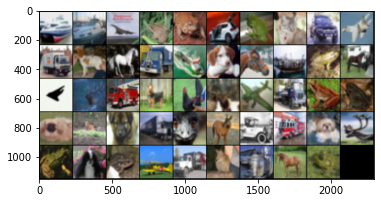

VAE reconstruction:


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


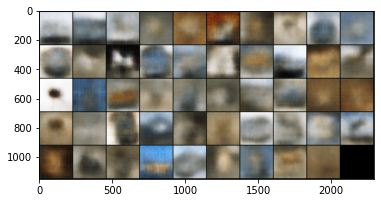

In [ ]:
images, labels = iter(valid_loader).next()

# First visualise the original images
print('Original images')
show_image(make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualize_reconstructions(images, resnet_vae)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, init='pca', random_state=42, perplexity=50)
imgs_ = []
labels_ = []
for i in range(100):
    imgs, labels = next(iter(train_loader))
    imgs_.append(imgs)
    labels_.append(labels)

imgs = torch.cat(imgs_, dim = 0)
labels = torch.cat(labels_, dim = 0)

latent_z , _, _ = resnet_vae.encode(imgs.cuda())
tsne_z = tsne.fit_transform(latent_z.cpu().detach().numpy())
labels = labels.data.numpy()